```
Project:  Fletcher
Date:     03/10/2017
Name:     Prashant Tatineni
```

# Project Overview

In this project, I use Twitter data to highlight the key issues being discussed related to the Demonetization event that occurred in India on January 1, 2017. Specifically, I use an old dataset of "tweets" with the tag #demonetization, downloaded via Kaggle, from late November 2016, when the Demonetization was announced. For comparison I also use tweets with the same tag downloaded via the Twitter API in March 2017.

## Summary of Solution Steps
1. Load the two sets of data.
2. Apply TF/IDF
3. Cluster using KMeans
4. Sentiment analysis in data

In [63]:
# imports

import pandas as pd
import nltk
from sklearn.cluster import KMeans
import re
import requests
from requests_oauthlib import OAuth1
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import silhouette_score
import pickle
import collections
from sklearn.decomposition import PCA
import unicodedata

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import cnfg
config = cnfg.load(".twitter_config")

oauth = OAuth1(config["consumer_key"],
               config["consumer_secret"],
               config["access_token"],
               config["access_token_secret"])

## Step 1: Load Data

In [ ]:
df = pd.read_csv('data/raw/demonetization-tweets.csv')

In [65]:
df.head()

,Unnamed: 0,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted
0,1,RT @rssurjewala: Critical question: Was PayTM ...,False,0,NaN,2016-11-23 18:40:30,False,NaN,801495656976318464,NaN,"<a href=""http://twitter.com/download/android"" ...",HASHTAGFARZIWAL,331,True,False
1,2,RT @Hemant_80: Did you vote on #Demonetization...,False,0,NaN,2016-11-23 18:40:29,False,NaN,801495654778413057,NaN,"<a href=""http://twitter.com/download/android"" ...",PRAMODKAUSHIK9,66,True,False
2,3,"RT @roshankar: Former FinSec, RBI Dy Governor,...",False,0,NaN,2016-11-23 18:40:03,False,NaN,801495544266821632,NaN,"<a href=""http://twitter.com/download/android"" ...",rahulja13034944,12,True,False
3,4,RT @ANI_news: Gurugram (Haryana): Post office ...,False,0,NaN,2016-11-23 18:39:59,False,NaN,801495527024160768,NaN,"<a href=""http://twitter.com/download/android"" ...",deeptiyvd,338,True,False
4,5,RT @satishacharya: Reddy Wedding! @mail_today ...,False,0,NaN,2016-11-23 18:39:39,False,NaN,801495445583360002,NaN,"<a href=""http://cpimharyana.com"" rel=""nofollow...",CPIMBadli,120,True,False


In [ ]:
# RESTful search API
all_tweets = []
search_url = "https://api.twitter.com/1.1/search/tweets.json"
parameters = {"q": "#demonetisation", "count":100, "lang": "en"}
response = requests.get(search_url,
                        params = parameters,
                        auth=oauth)

for tweet in response.json()['statuses']:
    all_tweets.append(tweet['text'])

for _ in range(99):
    if 'next_results' in response.json()['search_metadata'].keys():
        next_page_url = search_url + response.json()['search_metadata']['next_results']
        response = requests.get(next_page_url, auth=oauth)
        for tweet in response.json()['statuses']:
            all_tweets.append(tweet['text'])
    else:
        break

In [ ]:
X = pd.DataFrame(all_tweets)

In [ ]:
with open('data/new_tweets.pkl', 'wb') as picklefile:
    pickle.dump(X, picklefile)

## Step 2: Apply TF/IDF

In [67]:
def tokenize_func(text):
    if text[:2] == 'RT':
        text = text.partition(':')[2]
    tokens = nltk.word_tokenize(text)
    filtered_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z]', '', token).strip()
        if token not in ['demonetization','demonetisation','https','amp','rt','']:
            filtered_tokens.append(token)
    return filtered_tokens

In [68]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.97, min_df=0.03, max_features=200000,
                                 stop_words='english', decode_error='ignore',
                                 tokenizer=tokenize_func, ngram_range=(1,3))

In [69]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df['text']) #fit the vectorizer to tweets

CPU times: user 3.26 s, sys: 24.2 ms, total: 3.29 s
Wall time: 3.28 s


In [70]:
print tfidf_matrix.shape

(8000, 163)


In [71]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## Step 3: Kmeans Clustering

In [12]:
Inertia = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(tfidf_matrix)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(tfidf_matrix, labels, metric='euclidean'))
    Inertia.append(km.inertia_)

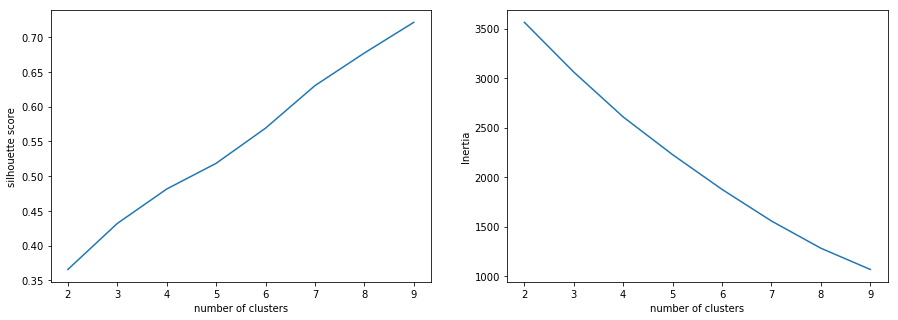

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette score')

# plot here on ax2
ax2.plot(k_clusters, Inertia)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia');

In [72]:
km = KMeans(n_clusters=3)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [74]:
collections.Counter(km.labels_)

Counter({0: 6876, 1: 542, 2: 582})

In [75]:
pca = PCA(n_components=2)
km_pca = pca.fit_transform(dist)
xs, ys = km_pca[:,0], km_pca[:,1]

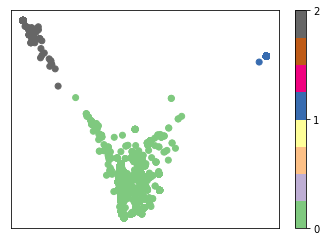

In [95]:
fig, ax = plt.subplots()
plt.scatter(xs,ys,c=clusters, cmap='Accent')
plt.colorbar(ticks=[0,1,2])
ax.tick_params(axis='x',bottom='off',labelbottom='off')
ax.tick_params(axis='y',left='off',labelleft='off')

In [77]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

In [78]:
terms = tfidf_vectorizer.get_feature_names()

In [98]:
for i in range(3):
    print('Cluster----------',i)
    for x in order_centroids[i,:10]:
        print(terms[x])

('Cluster----------', 0)
s
modi
people
narendramodi
pm
nt
india
support
t
govt
('Cluster----------', 1)
incident s
looted bank kishtwar
rs lakh looted
lakh looted bank
kishtwar j k
kishtwar j
k incident s
k incident
j k incident
s terrorists
('Cluster----------', 2)
ed
ua
ed ua
ed ub
ub
ed ua ubd
ua ubd
ua ubd ed
ubd ed ub
ubd ed


In [81]:
df['clusters'] = clusters

In [104]:
df[df.clusters == 1]['screenName'][4340]

'gauravcsawant'

## Step 4: Sentiment

In [106]:
df['sentiment'] = df['text'].apply(lambda x: TextBlob(unicode(x, errors='ignore')).sentiment[0])

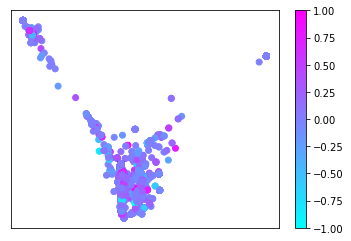

In [108]:
fig, ax = plt.subplots()
plt.scatter(xs,ys, c=df['sentiment'], cmap='cool')
plt.colorbar()
ax.tick_params(axis='x',bottom='off',labelbottom='off')
ax.tick_params(axis='y',left='off',labelleft='off')

In [117]:
df.sort_values('sentiment')['screenName'][6402]

'SwachhPolitics'

## Repeat above process with new tweets from API in March 2017

In [120]:
with open("data/new_tweets.pkl", 'rb') as picklefile: 
    new_tweets = pickle.load(picklefile)

In [3]:
new_tweets

,0
0,RT @steve_hanke: Indian economic indicators on...
1,RT @jairajp: Oops…! Looks like PayTM Boss is T...
2,RT @jairajp: Oops…! Looks like PayTM Boss is T...
3,Oops…! Looks like PayTM Boss is True Bhakt… Hi...
4,RT @bewithswami: Another example of #demoneti...
5,Another example of #demonetization failure -c...
6,RT @vinitgoenka: With the World Bank CEO laudi...
7,RT @vs_vanshi: Now confirmed..This is legalise...
8,RT @Prashantsameer: Is this benifit of #demone...
9,RT @vinitgoenka: With the World Bank CEO laudi...


In [121]:
new_tweets.columns = ['text']

In [122]:
%time tfidf2 = tfidf_vectorizer.fit_transform(new_tweets['text']) #fit the vectorizer to tweets

CPU times: user 860 ms, sys: 20.5 ms, total: 881 ms
Wall time: 871 ms


In [123]:
print tfidf2.shape

(2070, 162)


In [124]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf2)

In [125]:
km = KMeans(n_clusters=3)
km.fit(tfidf2)
clusters = km.labels_.tolist()

In [126]:
pca = PCA(n_components=2)
km_pca = pca.fit_transform(dist)
xs, ys = km_pca[:,0], km_pca[:,1]

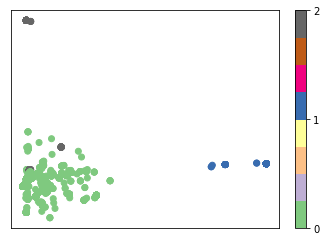

In [127]:
fig, ax = plt.subplots()
plt.scatter(xs,ys,c=clusters, cmap='Accent')
plt.colorbar(ticks=[0,1,2])
ax.tick_params(axis='x',bottom='off',labelbottom='off')
ax.tick_params(axis='y',left='off',labelleft='off')

In [128]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

In [129]:
terms = tfidf_vectorizer.get_feature_names()

In [130]:
for i in range(3):
    print('Cluster----------',i)
    for x in order_centroids[i,:10]:
        print(terms[x])

('Cluster----------', 0)
india
s
indias
new
bjp
cash
gdp
delhi
people
positive
('Cluster----------', 1)
thieving policy
slowed indian economy
thieving
policy slowed
policy slowed indian
thieving policy slowed
s thieving
s thieving policy
modi s thieving
slowed
('Cluster----------', 2)
modi
modi did past
country streets
streets
brought country streets
brought country
past brought country
past brought
did past brought
did past


In [26]:
collections.Counter(km.labels_)

Counter({0: 356, 1: 138, 2: 1576})

In [132]:
new_tweets['cluster'] = clusters

In [133]:
new_tweets[new_tweets.cluster == 1]

,text,cluster
150,RT @steve_hanke: Modi's thieving #Demonetizati...,1
213,RT @steve_hanke: Modi's thieving #Demonetizati...,1
299,RT @steve_hanke: Modi's thieving #Demonetizati...,1
356,Modi's thieving #Demonetization policy has slo...,1
360,RT @steve_hanke: Modi's thieving #Demonetizati...,1
373,RT @DrSalamAnsari: Modi's thieving #Demonetiza...,1
375,Modi's thieving #Demonetization policy has slo...,1
376,RT @steve_hanke: Modi's thieving #Demonetizati...,1
378,RT @steve_hanke: Modi's thieving #Demonetizati...,1
380,RT @steve_hanke: Modi's thieving #Demonetizati...,1


In [134]:
new_tweets['text'][1137]

u"Modi's thieving #Demonetization policy has slowed the Indian economy to worst Q growth since 2014. Not good folks. https://t.co/4WsSHNUjEx"

In [144]:
new_tweets['sentiment'] = new_tweets['text'].apply(lambda x: TextBlob(x).sentiment[0])

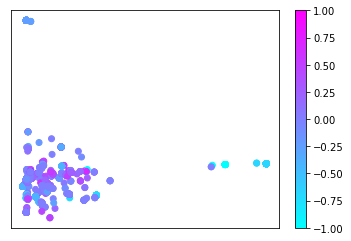

In [145]:
fig, ax = plt.subplots()
plt.scatter(xs,ys, c=new_tweets['sentiment'], cmap='cool')
plt.colorbar()
ax.tick_params(axis='x',bottom='off',labelbottom='off')
ax.tick_params(axis='y',left='off',labelleft='off')